In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Reading Files

In [12]:
df = pd.read_csv('../../data/processedData/training_data.csv')
df = df.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)

# Model Fitting

### Step 1: data preparation

In [13]:
# Split the dataset into training and testing sets
X = df.drop('Cardiovascular', axis=1)  # Features (drop the target variable 'Cardiovascular')
y = df['Cardiovascular']  # Target variable

# Split data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [14]:
len(X.columns)

32

### Step 2: Pipeline with Feature Selection and Hyperparameter Tuning for SVM Using GridSearchCV

In [15]:
# Define a Pipeline that includes standardization, feature selection, and the SVM model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization
    ('feature_selection', SelectKBest(f_classif)),  # Feature selection
    ('svm', SVC(probability=True))  # SVM model
])

# Define the hyperparameter search space
param_grid = {
    'feature_selection__k': [5, 10, 15, 20, 25],  # The number of features to select
    'svm__C': [0.1, 1, 10, 100],  # Regularization parameter for SVM
    'svm__gamma': [1, 0.1, 0.01, 0.001],  # Gamma parameter for the RBF kernel in SVM
    'svm__kernel': ['rbf']  # The kernel type used by SVM
}

# Perform a grid search with 20-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Perform hyperparameter search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'feature_selection__k': 10, 'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


### Step 3: Evaluate model performance on a test set

In [16]:
# Use the best model with optimal parameters to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8755
Precision: 0.8105
Recall: 0.6471
F1 Score: 0.7196


### Step 5: Plot the ROC curve

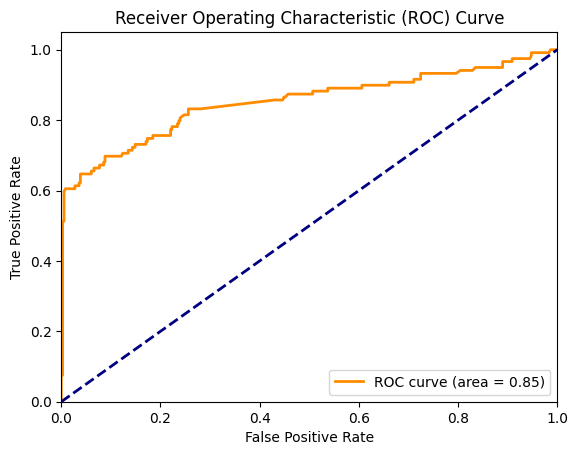

In [17]:
# Predict probabilities for the test set
y_score = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot diagonal line for random model
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title of the plot
plt.legend(loc="lower right")  # Display legend in the lower-right corner
plt.show()  # Display the ROC curve

#### Handling Imbalanced Data with Balanced Class Weights in SVM

In [18]:
print(y.value_counts())

Cardiovascular
0.0    1206
1.0     398
Name: count, dtype: int64


From the output it can be seen that the y data is unbalanced. There are 1206 samples with a category of 0.0, while there are only 398 samples with a category of 1.0. Typically, when there is a large difference in the number of samples between categories, the model may be biased towards predicting the category with the larger number during training.

Best Parameters:  {'feature_selection__k': 10, 'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Accuracy: 0.8548
Precision: 0.7025
Recall: 0.7143
F1 Score: 0.7083


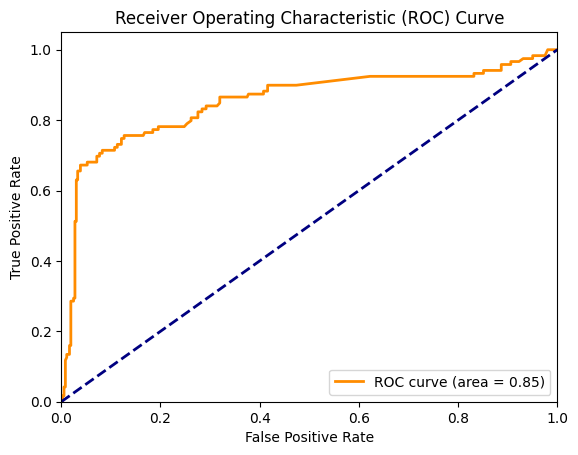

In [19]:
# Define a pipeline that includes standardization, feature selection, and SVM model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('feature_selection', SelectKBest(f_classif)),  # Feature selection
    ('svm', SVC(probability=True, class_weight='balanced'))  # SVM model, handles class imbalance
])

# Define the hyperparameter search space
param_grid = {
    'feature_selection__k': [5, 10, 15, 20, 25],  # Number of features to select in the feature selection step
    'svm__C': [0.1, 1, 10, 100],  # C parameter for SVM
    'svm__gamma': [1, 0.1, 0.01, 0.001],  # Gamma parameter for SVM
    'svm__kernel': ['rbf']  # SVM kernel function
}

# Perform hyperparameter tuning using 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Train on the training set while searching for the best parameters
grid_search.fit(X_train, y_train)

# Output the best parameter combination found
print("Best Parameters: ", grid_search.best_params_)

# Use the best model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Predict probabilities for the test set
y_score = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


After using `class_weight='balanced'`, the SVM's Recall increased from 0.6218 to 0.7143, indicating an improvement in the model's ability to identify positive samples (i.e., the minority class). However, Precision dropped from 0.9024 to 0.7025, which means the accuracy of the model's predictions decreased. Overall, this method prioritizes reducing missed positive samples but at the cost of some precision.

#### Handling Imbalanced Data Using SMOTE in SVM

Best Parameters:  {'feature_selection__k': 20, 'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Accuracy: 0.8755
Precision: 0.7658
Recall: 0.7143
F1 Score: 0.7391


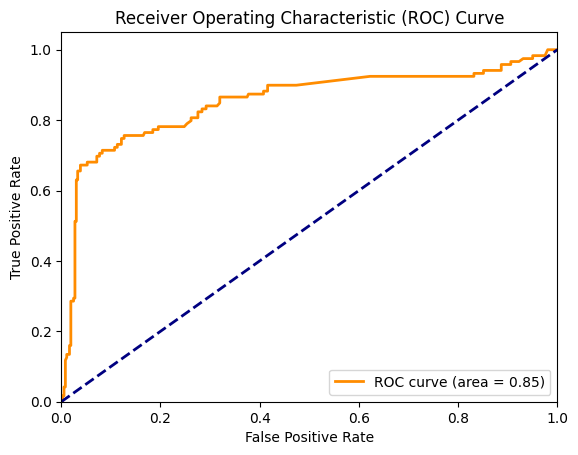

In [20]:
# Split the dataset into training and testing sets
X = df.drop('Cardiovascular', axis=1)  # Features (drop the target variable 'Cardiovascular')
y = df['Cardiovascular']  # Target variable
# Split the dataset into training and testing sets
X = df.drop('Cardiovascular', axis=1) 
y = df['Cardiovascular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(sampling_strategy=0.8, random_state=42)  
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define a pipeline that includes standardization, feature selection, and the SVM model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization
    ('feature_selection', SelectKBest(f_classif)),  # Feature selection
    ('svm', SVC(probability=True))  # SVM model
])

# Define the hyperparameter search space
param_grid = {
    'feature_selection__k': [5, 10, 15, 20, 25],  # Number of features to select
    'svm__C': [0.1, 1, 10, 100],  # Regularization parameter C for SVM
    'svm__gamma': [1, 0.1, 0.01, 0.001],  # Gamma parameter for the RBF kernel
    'svm__kernel': ['rbf']  # Kernel type for SVM
}

# Perform hyperparameter search with 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Train the model with SMOTE-balanced training data
grid_search.fit(X_train_smote, y_train_smote)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

# Use the best model to predict the test set
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The original SVM had the highest precision but lower recall. Using `class_weight='balanced'` improved recall but reduced precision and accuracy. SMOTE provided the best balance, improving recall while maintaining good precision and accuracy, making it the most effective approach.